# Classification of Kannada MNIST
<!-- ##  ![Preamble of kannada digits](img/kannada_numbers.jpg = 100x200) -->
<div>
<img src="attachment:Screenshot.png" width="500"/>
</div>



In [1]:
# Author: Vikas Chidananda 

# Dataset credits: Vinay Uday Prabhu
# Prabhu, V. (2019, August 03). Kannada-MNIST: A new handwritten DIGITS dataset 
#     for the Kannada language. Retrieved April 19, 2021, 
#     from https://arxiv.org/abs/1908.01242v1

### Numbers in Kannada

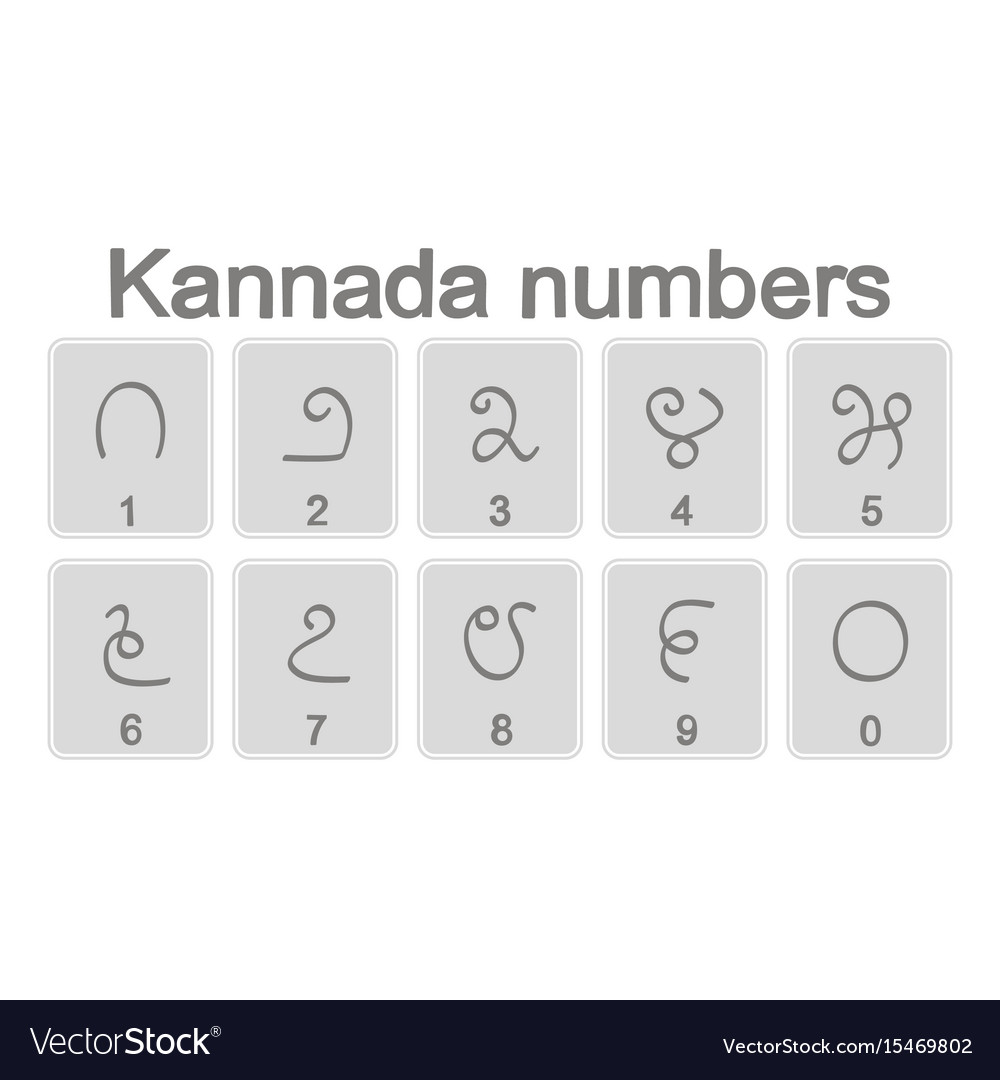

In [2]:
from IPython.display import Image
Image('img/kannada_numbers.jpg', width=400)

In [3]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt 
import matplotlib as mpl

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

font = {'size' : 10}
mpl.rc('font', **font)

In [4]:
import tensorflow as tf
from tqdm import tqdm

In [5]:
path_train_data = 'Kannada-MNIST_data/train.csv'
df_train = pd.read_csv(path_train_data)
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
labels, data = df_train['label'].to_numpy(), df_train.iloc[:, 1:].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, 
                                                                    test_size = 0.05, 
                                                                    random_state = 1)

In [7]:
num_labels, dim_data = len(np.unique(train_labels)), train_data.shape[-1], 
N_train_data, N_test_data = train_data.shape[0], test_data.shape[0]
# normalize the data
train_data = train_data/255.0
test_data = test_data/255.0

print(num_labels, dim_data)
print(N_train_data, N_test_data)

10 784
57000 3000


In [8]:
#size of the image = m x m
m = int(np.sqrt(dim_data))
print(m)

28


In [9]:
# store data as images
train_images = train_data.reshape(N_train_data, m, m, 1)
test_images = test_data.reshape(N_test_data, m, m, 1)

In [10]:
#helper function
def print_misclssified(predictions, true_labels):
    idxs = np.where(predictions != true_labels)
    idxs = idxs[0]
    num = len(idxs)
#     print(num)
    n = int(np.sqrt(num)) + 1
#     print(n)
    plt.figure(figsize=(20,20))
    
    for i in range(num):
        plt.subplot(n, n, i+1)

        image_ind = idxs[i]
        digit = test_data[image_ind]
        plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
        plt.xlabel('true:'+str(true_labels[image_ind])+' pred:'+str(predictions[image_ind] ))

## Visualize some of the data

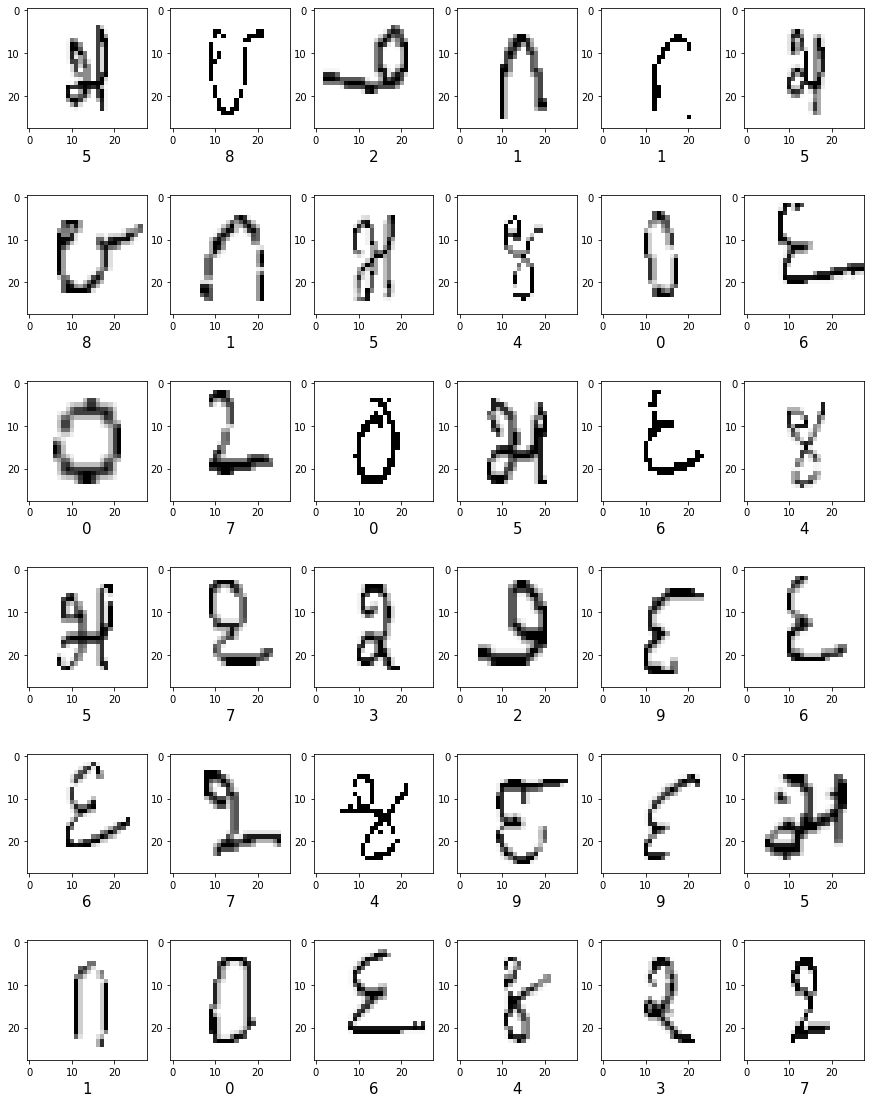

In [11]:
plt.figure(figsize=(15,20))
random_inds = np.random.choice(N_train_data,36)

for i in range(36):
    plt.subplot(6,6,i+1)

    image_ind = random_inds[i]
    digit = train_images[image_ind, :, :, 0]
    plt.imshow(digit, cmap = plt.cm.binary)
    plt.xlabel(train_labels[image_ind], fontsize = 15)

In [12]:
# To do improve image quality - discontinuity


### LDA and SVM

In [13]:
clf_lda = LDA()
%timeit clf_lda.fit(train_data, train_labels)

15.3 s ± 1.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(f'Score on trained data: {clf_lda.score(train_data, train_labels)}')
print(f'Score on test data: {clf_lda.score(test_data, test_labels)}')

Score on trained data: 0.9351403508771929
Score on test data: 0.9206666666666666


In [15]:
# Since most of the data is empty (0's) let's use LDA to reduce the data space
test_data_reduced = clf_lda.transform(test_data)
train_data_reduced = clf_lda.transform(train_data)
predict_lda = clf_lda.predict(test_data)

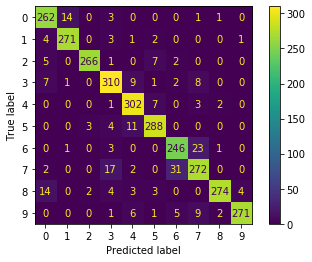

In [16]:
#confusion matrix
cm = confusion_matrix(test_labels, predict_lda, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

In [17]:
clf_svm = svm.LinearSVC(C = 0.01,
                penalty='l2',
                loss='squared_hinge',
                tol=0.0001,
                multi_class='ovr')
clf_svm.fit(train_data, train_labels) 
      
clf_svm.score(test_data, test_labels)

0.9553333333333334

In [18]:
clf_svm_reduced = svm.LinearSVC(C = 0.01,
                penalty='l2',
                loss='squared_hinge',
                tol=0.0001,
                multi_class='ovr')
clf_svm_reduced.fit(train_data_reduced, train_labels)
clf_svm_reduced.score(test_data_reduced, test_labels)

0.9253333333333333

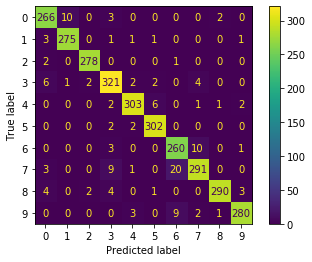

In [19]:
#confusion matrix
predict_svm = clf_svm.predict(test_data)
cm = confusion_matrix(test_labels, predict_svm, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

## Deeplearning (NN) with different architectures

In [20]:
def build_model():                                                 #layers as arguments
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return nn_model

model = build_model()

In [21]:
%load_ext tensorboard
import datetime

In [22]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H$M$S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
batch_size = 32
epochs = 5

model.fit(train_data, 
          train_labels, 
          batch_size = batch_size, 
          epochs = epochs,
          callbacks = [tensorboard_callback])

Epoch 1/5
1782/1782 [==============================] - 18s 7ms/step - loss: 0.1853 - accuracy: 0.9461
Epoch 2/5
1782/1782 [==============================] - 13s 7ms/step - loss: 0.0765 - accuracy: 0.9770
Epoch 3/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0532 - accuracy: 0.9845
Epoch 4/5
1782/1782 [==============================] - 12s 7ms/step - loss: 0.0394 - accuracy: 0.9882
Epoch 5/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0284 - accuracy: 0.9919


In [24]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13732), started 1 day, 3:47:38 ago. (Use '!kill 13732' to kill it.)

In [25]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('Test accuracy:', test_acc, test_loss)

94/94 - 1s - loss: 0.0471 - accuracy: 0.9827
Test accuracy: 0.9826666712760925 0.04710382595658302


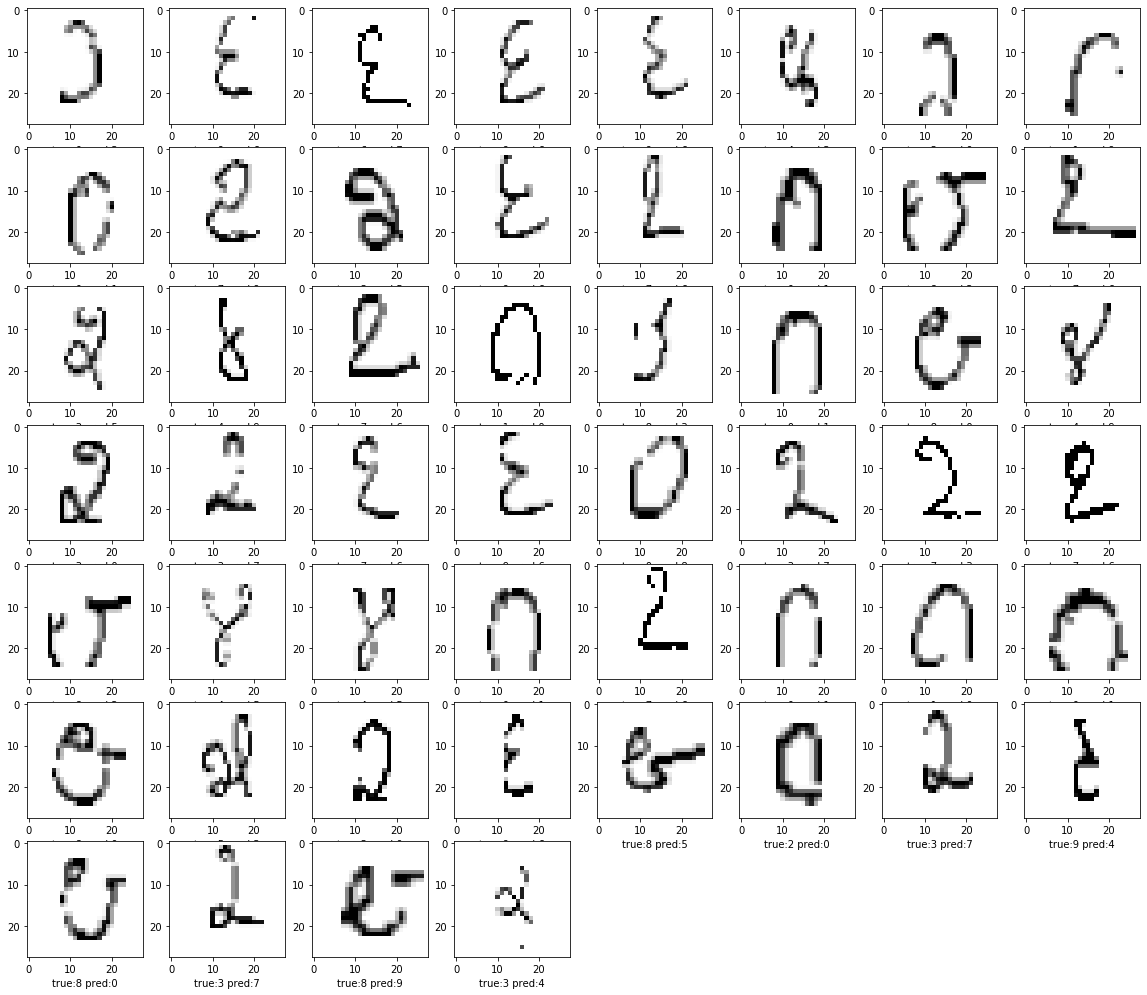

In [26]:
prediction_nn = np.argmax(model.predict(test_data), axis = -1)
print_misclssified(prediction_nn, test_labels)

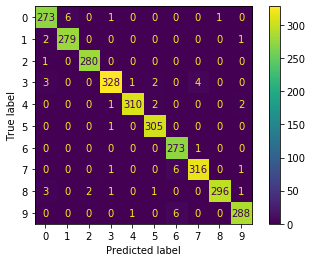

In [27]:
cm = confusion_matrix(test_labels, prediction_nn, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


### With different architectures

In [29]:
def build_model_arch(layers):
    model = tf.keras.Sequential([])
    for i in range(len(layers)):
        model.add(tf.keras.layers.Dense(layers[i], activation = 'relu'))
                  
    model.add(tf.keras.layers.Dense(num_labels, activation = 'sigmoid'))
    return model

#### Deep v/s shallow

In [30]:
deep_layers = np.array([256, 128, 64], dtype = int)
shallow_layers = np.array([128, 128])
deep_nn = build_model_arch(deep_layers)
shallow_nn = build_model_arch(shallow_layers)
models = [deep_nn, shallow_nn]

In [31]:
batch_size = 32
epochs = 5
summary = []
test_scores = []

for model in models:
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
    
    model.fit(train_data, 
          train_labels, 
          batch_size = batch_size, 
          epochs = epochs)
    
    _, test_score = model.evaluate(test_data, test_labels)
    
    test_scores.append(test_score)
    summary.append(model.history)
    

Epoch 1/5
1782/1782 [==============================] - 14s 7ms/step - loss: 0.1785 - accuracy: 0.9469
Epoch 2/5
1782/1782 [==============================] - 12s 7ms/step - loss: 0.0640 - accuracy: 0.9808
Epoch 3/5
1782/1782 [==============================] - 12s 7ms/step - loss: 0.0430 - accuracy: 0.9869
Epoch 4/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0276 - accuracy: 0.9920
Epoch 5/5
94/94 [==============================] - 1s 5ms/step - loss: 0.0529 - accuracy: 0.9827
Epoch 1/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.1872 - accuracy: 0.9466
Epoch 2/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0787 - accuracy: 0.9761
Epoch 3/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0539 - accuracy: 0.9835
Epoch 4/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0399 - accuracy: 0.9885
Epoch 5/5
94/94 [==============================] - 1s 5ms/step - loss: 0.0543 - accurac

In [43]:
#histograms of wrongly predicted labels
shallow_nn.summary()
test_scores[1]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


0.9833333492279053

In [44]:
deep_nn.summary()
test_scores[0]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


0.9826666712760925

### CNN with different architecture

In [34]:
def CNN_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(24, 3, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(36, 2, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return cnn_model

In [35]:
cnn_model = CNN_model()
cnn_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [37]:
batch = 64
epochs = 5

cnn_model.fit(train_images, train_labels, 
              batch_size = batch, 
              epochs=epochs)

Epoch 1/5
891/891 [==============================] - 28s 10ms/step - loss: 0.2113 - accuracy: 0.9362
Epoch 2/5
891/891 [==============================] - 9s 10ms/step - loss: 0.0597 - accuracy: 0.9820
Epoch 3/5
891/891 [==============================] - 9s 10ms/step - loss: 0.0393 - accuracy: 0.9877
Epoch 4/5
891/891 [==============================] - 9s 10ms/step - loss: 0.0313 - accuracy: 0.9903
Epoch 5/5
891/891 [==============================] - 9s 10ms/step - loss: 0.0254 - accuracy: 0.9921


In [38]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 36)        3492      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               166016    
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [39]:
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print(f'test accuracy : {test_acc} \t test loss: {test_loss}')

94/94 [==============================] - 1s 7ms/step - loss: 0.0383 - accuracy: 0.9897
test accuracy : 0.9896666407585144 	 test loss: 0.03831949457526207


In [41]:
#what did we classify wrongly?
predictions = cnn_model.predict(test_images)
predictions = np.argmax(predictions, axis = -1)
idxs = np.where(predictions != test_labels)
misclassified_labels = predictions[idxs]

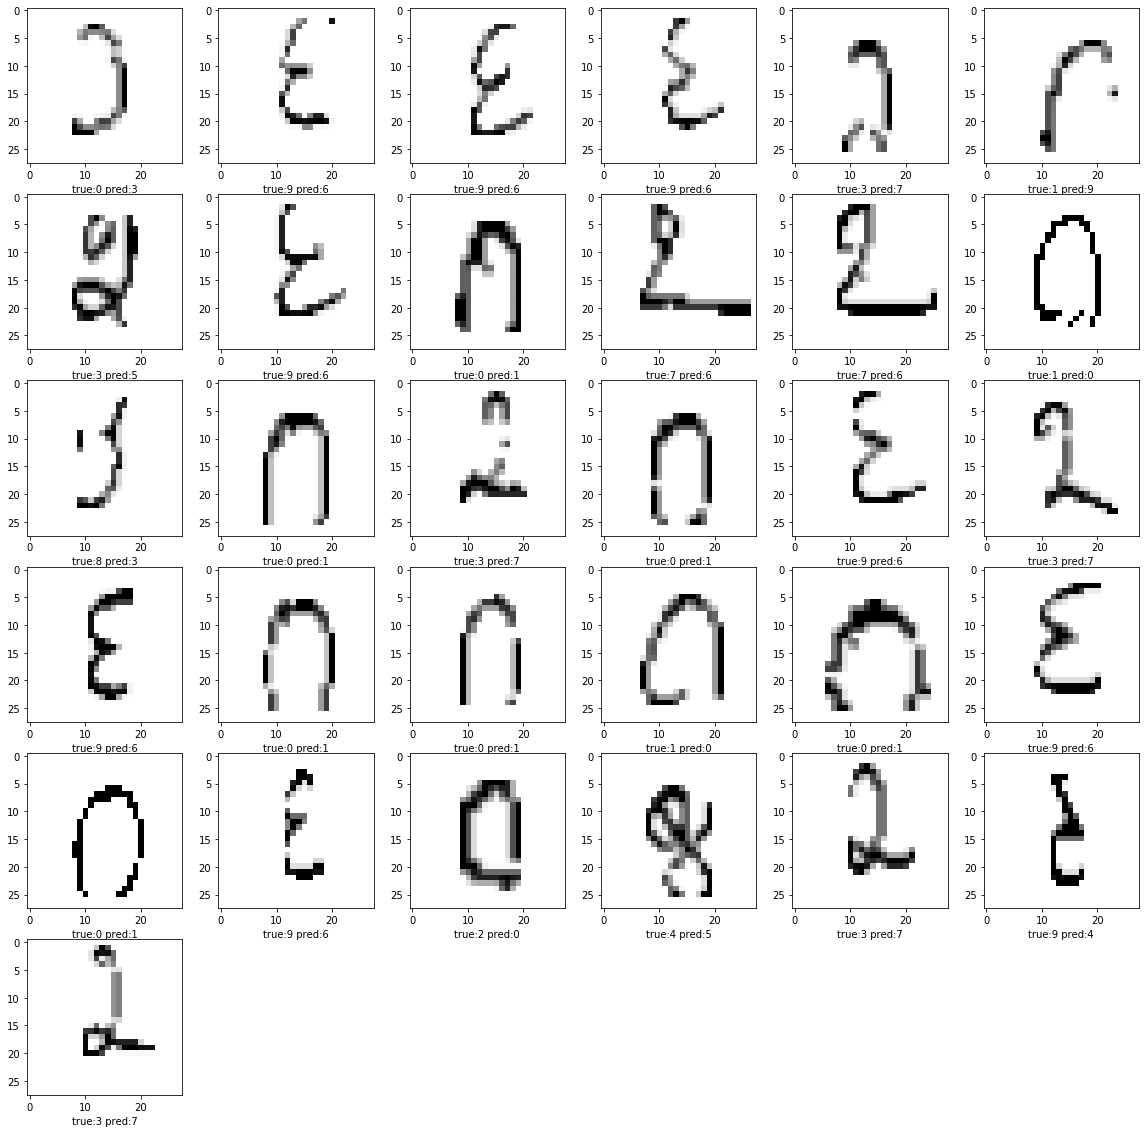

In [42]:
print_misclssified(predictions, test_labels)

### Using Alexnet